In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
co_purchased = pd.read_feather('./Data/co_purchased.ftr')
products = pd.read_feather('./Data/products.ftr')
reviews = pd.read_feather('./Data/reviews.ftr')

In [3]:
from joblib import dump, load
logreg = load('logreg.joblib')
encoder = load('encoder.joblib') 

In [161]:
def preprocessing_pipeline(temp):
    temp1 = products.set_index('product_id').reindex(index=temp['first'])
    temp1.columns = [col+'1' for col in temp1.columns]
    temp2 = products.set_index('product_id').reindex(index=temp['second'])
    temp2.columns = [col+'2' for col in temp2.columns]
    dataset = temp1.reset_index(drop=True).join(temp2.reset_index(drop=True)).dropna().reset_index(drop=True)
    dataset['sales_diff'] = dataset['salesrank1'] - dataset['salesrank2']
    dataset['co_purchased_diff'] = dataset['co_purchased_num1'] - dataset['co_purchased_num2']

    dataset['reviews_num_diff'] = dataset['reviews_num1'] - dataset['reviews_num2']
    dataset['avg_rating_diff'] = dataset['avg_rate1'] - dataset['avg_rate2']
    dataset['first_time_diff'] = dataset['first_rating_time1'] - dataset['first_rating_time2']
    dataset['last_time_diff'] = dataset['last_rating_time1'] - dataset['last_rating_time2']
    dataset['highest_rating_diff'] = dataset['highest_rate1'] - dataset['highest_rate2']
    dataset['lowest_rating_diff'] = dataset['lowest_rate1'] - dataset['lowest_rate2']
    def calc_categ_simi(list1, list2):
        set1, set2 = set(list1), set(list2)
        join = set1 | set2
        return len(set1 & set2) / len(join) if len(join) != 0 else 0
    dataset['categ_simi'] = dataset.apply(lambda x: 
            calc_categ_simi(x['categories1'], x['categories2']), axis=1)

    dataset.drop(columns=['categories1', 'categories2'], inplace=True)
    dataset.drop(columns=['title1', 'title2'], inplace=True)

    X = pd.concat([pd.DataFrame(MinMaxScaler().fit_transform(dataset.drop(columns=['group1', 'group2']))), 
                pd.DataFrame(encoder.transform(dataset[['group1', 'group2']]))], axis=1)
    cols = list(dataset.drop(columns=['group1', 'group2']).columns)
    cols.extend(list(encoder.get_feature_names_out(['group1', 'group2'])))
    X.columns = cols
    support = [True,  True,  True, False, False, False, False, False,  True,
               True,  True,  True,  True,  True, False, False,  True, False,
               True,  True, False, False,  True,  True,  True, False,  True,
               False, False,  True,  True, False, False, False, False, False,
               False, False, False, False, False, False,  True,  True, False]
    
    return X[X.columns[support]]


In [129]:
# Given a product, return a list of potential customers
bought_product = '0385411472'

its_customers = set(reviews.loc[reviews['product_id'] == bought_product, 'customer_id'])

temp = co_purchased.loc[co_purchased['second']==bought_product]
temp.columns = ['second', 'first']
temp = pd.concat([co_purchased.loc[co_purchased['first']==bought_product],
                  temp]).reset_index(drop=True)

dataset = preprocessing_pipeline(temp)
strength = logreg.predict_proba(dataset)[:, 1]

ranked_products = pd.DataFrame([[x, y] for y,x in sorted(zip(strength, temp['second']), reverse=True)], columns=['product_id', 'strength'])

result = reviews.loc[reviews['product_id'].isin(ranked_products['product_id']), ['product_id', 'customer_id']]

result = result.set_index('product_id').join(ranked_products.set_index('product_id'), how='left')
result = result.drop_duplicates(subset='customer_id', keep="first")
result = result[~result['customer_id'].isin(its_customers)].sort_values(by='strength', ascending=False).reset_index(drop=True)
result['strength'] = [f'{s*100:.2f}%' for s in result['strength']]
result.columns = ['potential_customers', 'strength']

result

,potential_customers,strength
0,A9Y05AGWAVY9V,100.00%
1,A31TVU8SBCCYHQ,100.00%
2,A1ZXXCE6SRQM9I,100.00%
3,A37I2PJG90RAZO,100.00%
4,A11D59W5BBPJPK,100.00%
...,...,...
56,AID6X4N2TXYGE,90.85%
57,A32EH1093C06O7,0.00%
58,A140XH16IKR4B0,0.00%
59,A2ZZM7Q55ZZEXY,0.00%


In [130]:
# Given a customer, return a list of potential products based on co_purchasing patterns
customer = 'A2JW67OY8U6HHK'

bought_products = set(reviews.loc[reviews['customer_id'] == customer, 'product_id'])
temp = co_purchased.loc[co_purchased['second'].isin(bought_products)]
temp.columns = ['second', 'first']
temp = pd.concat([co_purchased.loc[co_purchased['first'].isin(bought_products)],
                  temp]).reset_index(drop=True)

dataset = preprocessing_pipeline(temp)
strength = logreg.predict_proba(dataset)[:, 1]

ranked_products = pd.DataFrame([[x, f'{y*100:.2f}%'] for y,x in sorted(zip(strength, temp['second']), reverse=True)], columns=['potential_products', 'strength'])
ranked_products = ranked_products.drop_duplicates(subset='potential_products', keep="first").reset_index(drop=True)

ranked_products

,potential_products,strength
0,0805415505,99.99%
1,0687023955,99.99%
2,0804215715,97.64%
3,156101074X,1.36%
4,082721619X,0.89%
5,0802842623,0.00%
6,title0687074231,0.00%


In [87]:
test_products = co_purchased['second'].sample(2, random_state=12345)
probs = []

temp1 = pd.DataFrame()
temp1['first'] = products['product_id']
temp2 = pd.DataFrame()
temp2['second'] = test_products
temp1['key'] = 1
temp2['key'] = 1
temp = pd.merge(temp1, temp2, on ='key').drop("key", 1)
dataset = preprocessing_pipeline(temp)
strength = logreg.predict_proba(dataset)[:, 1]

strength

array([0.00232489, 0.00104729, 0.00021296, ..., 0.00075311, 0.00071857,
       0.00039107])

In [ ]:
test_products = co_purchased['second'].sample(10, random_state=12345)
probs = []

for tp in test_products:
    if len(products[products['product_id']==tp])==0:
        probs.append(np.nan)
        continue
    temp = pd.DataFrame()
    temp['first'] = products['product_id']
    temp['second'] = tp
    dataset = preprocessing_pipeline(temp)
    temp['strength'] = logreg.predict_proba(dataset)[:, 1]
    temp = temp.sort_values(by='strength', ascending=False)
    temp.drop(columns=['second'], inplace=True)
    temp.columns = ['product_id', 'strength']
    temp = temp.reset_index(drop=True)
    temp = temp[temp['product_id'].isin(co_purchased.loc[co_purchased['second']==tp, 'first'])].reset_index()
    prob = len(temp[temp['strength']>0.5])/len(temp) if len(temp) != 0 else np.nan
    probs.append(prob)

probs

In [70]:
np.nanmean(probs)

0.3257656695156695

In [210]:
test_products = co_purchased['first'].sample(100, random_state=12345)
positives = []
negatives = []

for tp in test_products:
    if len(products[products['product_id']==tp])==0:
        continue
    temp = pd.DataFrame()
    temp['second'] = products['product_id']
    temp['first'] = tp
    dataset = preprocessing_pipeline(temp)
    temp['strength'] = logreg.predict_proba(dataset)[:, 1]
    temp = temp.sort_values(by='strength', ascending=False)
    temp.drop(columns=['first'], inplace=True)
    temp.columns = ['product_id', 'strength']
    temp = temp.reset_index(drop=True)
    p1 = temp.loc[temp['product_id'].isin(co_purchased.loc[co_purchased['first']==tp, 'second']), 'strength'].mean()
    p0 = temp.loc[~temp['product_id'].isin(co_purchased.loc[co_purchased['first']==tp, 'second']), 'strength'].mean()
    if math.isnan(p1) or math.isnan(p0):
        continue
    positives.append(p1)
    negatives.append(p0)
    if len(positives) >= 10:
        break

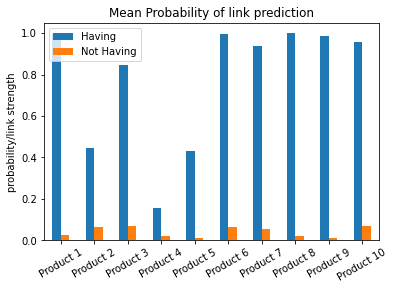

In [211]:
fig, (ax1) = plt.subplots(1, figsize=(6, 4))

df = pd.DataFrame()
df['Having'] = positives
df['Not Having'] = negatives
df.dropna(inplace=True)
df['table'] = [f'Product {i+1}' for i in range(len(df))]
df.plot.bar(ax=ax1)
ax1.set_ylabel('probability/link strength')
ax1.set_xticklabels(df['table'], rotation=30)
ax1.set_title('Mean Probability of link prediction')

plt.show()

In [63]:
new_coming = '1930519206'
temp = pd.DataFrame()
temp['first'] = products['product_id']
temp['second'] = new_coming
dataset = preprocessing_pipeline(temp)
temp['strength'] = logreg.predict_proba(dataset)[:, 1]
temp = temp.sort_values(by='strength', ascending=False)
temp.drop(columns=['second'], inplace=True)
temp.columns = ['product_id', 'strength']
temp = temp[:5]
temp = temp.set_index('product_id').join(reviews[['product_id', 'customer_id']].set_index('product_id'), how= 'left').reset_index(drop=True)
temp = temp[['customer_id', 'strength']].sort_values(by='strength', ascending=False).drop_duplicates(subset='customer_id', keep="first")
temp['strength'] = [f'{s*100:.2f}%' for s in temp['strength']]
temp = temp.drop_duplicates(subset='customer_id', keep="first").reset_index(drop=True)
temp.columns = ['potential_customer', 'strength']

temp

,potential_customer,strength
0,A1VCFMW5VP3JXN,99.82%
1,A3H48OXCO0UE7L,99.82%
2,A1PUJ0NFE9BIZC,99.82%
3,A3195MG8D8VKQJ,99.82%
4,A3807IWWRU1V0D,99.82%
5,ATVPDKIKX0DER,99.82%
6,A298SQ7KBSOMKC,99.82%
7,A1T1MKDHCNCG06,99.82%
8,A2WWGDZYCHOAEB,99.80%
9,A1C19UVH4PAFX8,99.80%
